(1) Import Libraries and define constants

In [3]:
import numpy as np
import scipy 
import os
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
from scipy import ndimage
import sys
import math
from PIL import Image
from skimage import io

In [4]:
# Global Constants
side_length = 150
image_path = "./Logistic_Regression_Data/"
test_ratio = .3
epoch = 1000
learning_rate = .02
max_num_images = -1

(2) Create train and test examples:

In [29]:
def getImageArrays(path, side_length): #returns list of images arrays for a specified path
    image_names = os.listdir(path)
    image_names = image_names[:max_num_images]
    examples = []
    for image_name in image_names:
        if image_name.split(".")[-1] != "DS_Store":
            try:
                cur_image_path = path + image_name
                cur_image = np.array(ndimage.imread(cur_image_path,flatten=False))
                cur_array_resized = scipy.misc.imresize(cur_image,size=(side_length,side_length))
                cur_array_flattened = cur_array_resized.reshape((side_length*side_length*3)).T
                examples += [cur_array_flattened] 
            except ValueError:
                print("Error in creating examples",image_name)
    return examples

In [6]:
#create examples & labels
cow_images_path = image_path + "cows/"
notCow_image_path = image_path + "notcows/"


examples_cow = getImageArrays(cow_images_path, side_length)
examples_notCow = getImageArrays(notCow_image_path, side_length)

labels_cow = np.ones(len(examples_cow))
labels_notCow = np.zeros(len(examples_notCow))

examples = np.concatenate((examples_cow,examples_notCow))
labels = np.concatenate((labels_cow,labels_notCow))

assert(len(examples) == len(labels)), "labels and examples don't match"

Error in creating examples notcow126.jpg
Error in creating examples notcow472.jpg


In [7]:
shuffled_indexing = np.random.permutation(labels.shape[0])
examples = examples[shuffled_indexing]
labels = labels[shuffled_indexing]

In [8]:
#seperate train and test examples
number_examples_test = int(len(examples)*test_ratio)
number_labels_test = int(len(labels)*test_ratio)

examples_test = examples[:number_examples_test]
examples_train = examples[number_examples_test:]
labels_test = labels[:number_labels_test]
labels_train = labels[number_labels_test:]
print("Number of training examples: ", examples_train.T.shape[1])
print("Number of test examples: ", examples_test.T.shape[1])

Number of training examples:  712
Number of test examples:  304


In [9]:
#reshape labels and examples for future matrix operations
labels_train = np.reshape(labels_train,(1,len(labels_train)))
labels_test = np.reshape(labels_test,(1,len(labels_test)))
examples_train = examples_train.T
examples_test = examples_test.T

In [10]:
# Standardize color values of the image (decrease computational cost durring cross entropy)
standardized_train_examples = examples_train/255 #225 is the maximum rgb value/ This is done to decrease varaince in inputs thus more efficint
standardized_test_examples = examples_test/255
print("Final Shapes:", "test:", standardized_test_examples.shape, "train:", standardized_train_examples.shape)

Final Shapes: test: (67500, 304) train: (67500, 712)


(3) Defeine basic functions

In [11]:
def sigmoid(x):
    output = 1.0/(1.0+np.exp(-x))
    return output

In [12]:
def initialize_zeros(dimension): #dimension = len(flattened_examples)
    zeroed_weights = np.zeros((dimension, 1)) 
    zeroed_baisies = 0. #baisies always start at 0 b/c they are developed as the model trains
    assert(isinstance(zeroed_baisies, float) or isinstance(zeroed_baisies, int))
    return zeroed_weights, zeroed_baisies

In [13]:
def crossEntropyLoss(a,Y):
    m = Y.shape[1] #len(Y) doesn't work, need 2nd dimesnion
    #prevents log of zero 
    a[0][a[0]==1] = .999
    a[0][a[0]==0] = .001
    loss = -(1.0 / m) * np.sum(Y * np.log(a) + (1.0 - Y) * np.log(1.0 - a))
#     loss = (- 1.0 / m) * np.sum(Y * np.log(a) + (1.0 - Y) * (np.log(1.0 - a)))
    return loss

(4) Foward Pass

In [14]:
def propagate(X,Y,w,b):
    w_transposed = w.T
    num_of_examples = np.shape(X)[1]
    dot_product = np.dot(w_transposed,X)
    z = dot_product + b
    a = sigmoid(z) #in begining should be 0
    loss = crossEntropyLoss(a,Y)
    #1/m becuase loss uses 1/m 
    dw = (1.0/num_of_examples) * np.dot(X,(a-Y).T) 
    db = (1.0/num_of_examples) * np.sum(a-Y) #np.sum collapes input
    loss = np.squeeze(loss)
    grads = {"dw":dw,"db":db}
    return grads,loss    


In [15]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(X, Y,w,b)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.99845601]
 [ 2.39507239]]
db = 0.00145557813678
cost = 5.80154531939


(5) Optimize

In [16]:
def optimizer(w, b, X, Y, learning_rate, epoch, print_results=True):
    sample_costs = []
    costs = []
    for i in range(epoch):
        grads, cost = propagate(X,Y,w,b)
        dw = grads["dw"]
        db = grads["db"]
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        costs += [cost]
        
        if print_results:
            optimizerPrinter(costs,epoch)
        if (i % 10 == 0):
            sample_costs += [cost]            
            costs += [cost]            
    grads = {"dw":dw,"db":db}
    params = {"w":w,"b":b}
    return grads,params,costs

In [17]:
def optimizerPrinter(costs,epoch):
    starting_costs = costs[:int(epoch * .09)] #gets the first 9 percent of costs, used as a baseline
    recent_costs = costs[-10:] #get the most recent 10 costs
    avg_recent_costs = sum(recent_costs)/len(recent_costs)
    avg_starting_costs = sum(starting_costs)/len(starting_costs)
    percent = ((len(costs))/epoch) * 100
    if (len(costs) % int(epoch/(10)) == 0.0) and (len(costs) != 1):
        percent = math.ceil(percent * .1) * 10
    cur_cost = costs[-1]
    if cur_cost > 999: #only display three place values
        cur_cost = 999
    if avg_starting_costs > 999:
        avg_starting_costs = 999
    if avg_recent_costs > 999:
        avg_recent_costs = 999
    sys.stdout.write('\r') #writes in same line
    sys.stdout.write(
        str(int(percent)).zfill(2) + "% " +
        "Cur Cost: " + str(cur_cost).zfill(3) +
        " Recent Costs: " + str(avg_recent_costs).zfill(3) + 
        " Starting Costs: " + str(avg_starting_costs).zfill(3))
    sys.stdout.flush()
    if (len(costs) % int(epoch/(10)) == 0.0) and (len(costs) != 1):
        print("") #creates a new line
    

In [18]:
# w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
# grads,params,cost = optimizer(w,b,X, Y, .009, 143, print_results=True)
# print ("w = " + str(params["w"]))
# print ("b = " + str(params["b"]))
# print ("dw = " + str(grads["dw"]))
# print ("db = " + str(grads["db"]))

(6) Validate

In [19]:
def predictor(X,w,b):
    w_transposed = w.T
    prediction = (np.dot(w_transposed,X)) + b
    prediction = sigmoid(prediction)
    prediction *= 2.0 # so prediction is either 1 or -1
    prediction = np.floor(prediction)
    return prediction

In [20]:
w = np.array([[0.1124], [0.231]])
b = -.3
X = np.array([[1,-1.1,-3.2],[1.2,2,.1]])
print(predictor(X,w,b))

[[ 1.  1.  0.]]


(7) Driver

In [21]:
def logisticRegression(train_X,train_Y,test_X,test_Y,learning_rate,epoch):
    assert(train_X.shape[1] == train_Y.shape[1]), "train exampes dimensions invalid: Train X " + train_X.shape + " Train Y " + train_Y.shape

    #Inialize w/b
    w,b = initialize_zeros(side_length*side_length*3)
    
    #Train
    grads, params, costs = optimizer(w, b, train_X, train_Y, learning_rate, epoch)
    w, b = params["w"], params["b"]

    #Eval
    prediction_train = predictor(train_X,w,b)
    accuracy_train = np.mean(np.abs(prediction_train - train_Y))
    print(accuracy_train, "train accuracy")
    accuracy_output = "train accuracy {} %" .format(100 - (accuracy_train * 100))
    print(accuracy_output)
    
    #Test
    prediction_test = predictor(test_X,w,b)
    accuracy_test = np.mean(np.abs(prediction_test - test_Y))
    print(accuracy_test, "test accuarcy")
    accuracy_output = "Actural accuarcy {} %" .format(100 - (accuracy_test * 100))
    print(accuracy_output)
    
    d = {
        "costs": costs,
        "Y_prediction_test" : prediction_test,
        "X_prediction_train" : prediction_train,
        "w" : w,
        "b" : b,
        "learning rate" : learning_rate,
        "epoch" : epoch
    }
    return d
        

In [22]:
train_X = standardized_train_examples
train_Y = labels_train
test_X = standardized_test_examples
test_Y = labels_test

# print(train_X.shape,"train_X")
# print(train_Y.shape,"train_Y")
# print(test_X.shape,"test_X")
# print(test_Y.shape,"test_Y")

d = logisticRegression(train_X,train_Y,test_X,test_Y,learning_rate,epoch)
print("Complete :)") 

10% Cur Cost: 5.14760879056 Recent Costs: 11.0687932255 Starting Costs: 13.8669093511
30% Cur Cost: 4.47710535491 Recent Costs: 4.21744917398 Starting Costs: 13.8669093511
40% Cur Cost: 3.1380326807 Recent Costs: 5.8600331148 Starting Costs: 13.866909351111
50% Cur Cost: 11.7825936109 Recent Costs: 9.79687439663 Starting Costs: 13.8669093511
60% Cur Cost: 5.33709305786 Recent Costs: 4.52190380696 Starting Costs: 13.8669093511
70% Cur Cost: 2.82424765904 Recent Costs: 2.88479788653 Starting Costs: 13.8669093511
80% Cur Cost: 4.74991637997 Recent Costs: 9.12386823191 Starting Costs: 13.8669093511
90% Cur Cost: 5.26811787518 Recent Costs: 6.80916537514 Starting Costs: 13.8669093511
100% Cur Cost: 1.7177581295 Recent Costs: 2.20425253026 Starting Costs: 13.86690935111
120% Cur Cost: 1.11774942671 Recent Costs: 1.03113207873 Starting Costs: 13.866909351111
0.328651685393 train accuracy
train accuracy 67.13483146067415 %
0.467105263158 test accuarcy
Actural accuarcy 53.28947368421053 %
Compl

In [23]:
def classify(d, image_path, print_output=True, show=True):
    if (image_path.split(":")[0] == "http") or (image_path.split(":")[0] == "https"):
        try:
            image = io.imread(image_path)
        except:
            print("Sorry, but this url forbids requests from machines :(")
            return
    else:
        image = np.array(ndimage.imread(image_path, flatten=False))
    w = d["w"]
    b = d["b"]
    side_length = int((w.shape[0]/3) ** .5)
    array_resized = scipy.misc.imresize(image, size=(side_length,side_length))
    array_flattened = array_resized.reshape((side_length*side_length*3)).T
    array_standardized = array_flattened/225
    label = predictor(array_standardized,w,b)
    label = int(label[0])
    if show == True:
        io.imshow(image)
        io.show()
    if print_output == True:
        if int(label) == 0:
            print("You don't have a cow")
        if int(label) == 1:
            print("Mooooooo")
    return label

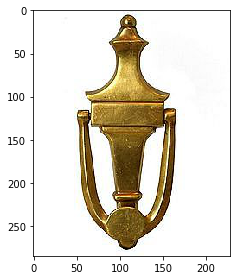

You don't have a cow


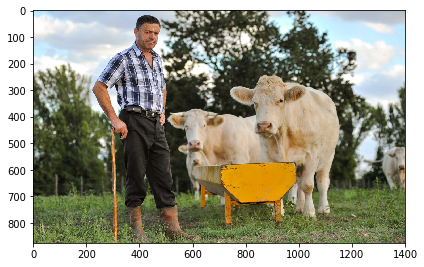

Mooooooo


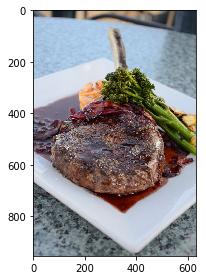

You don't have a cow


0

In [24]:
classify(d, "./Logistic_Regression_Data/notcows/notcow7.jpg")
url = "https://images.unsplash.com/photo-1469365897239-504fabc9b11b?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=1a1886339e4b1fd59eb0ae330b150899&auto=format&fit=crop&w=1400&q=80"
classify(d, url)
url = "https://images.unsplash.com/photo-1432139509613-5c4255815697?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=616fc216eff2732910545ebd5d5018b6&auto=format&fit=crop&w=632&q=80"
classify(d, url)

In [25]:
def compare_runs(train_X,train_Y,test_X,test_Y, run_params):
    for run in run_params:
        cur_learning_rate = run["learning_rate"]
        cur_epoch = run["epoch"]
        print("Run {epoch: " + str(cur_epoch) + ", lr: " + str(cur_learning_rate) + "}")
        cur_d = logisticRegression(train_X,train_Y,test_X,test_Y,cur_learning_rate,cur_epoch)
        cur_costs = cur_d["costs"]
        cur_label = "epoch: " + str(cur_epoch) + ", lr: " + str(cur_learning_rate)
        plot_costs(cur_costs,cur_label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
        
        
        
        
        
    

In [26]:
def plot_costs(run_costs,label=None):
    sample_timestep = 10
    x = np.arange(0,len(run_costs),sample_timestep) 
    grouped_run_costs = np.array(np.array_split(run_costs,sample_timestep)).T #make array so can transpose
    print("x",np.shape(x))
    print("grouped",np.shape(grouped_run_costs))
    print("run",np.shape(run_costs))
    avg_run_costs = [sum(chunk)/sample_timestep for chunk in grouped_run_costs]
    print("avg_run", np.shape(avg_run_costs))
    print("x", np.shape(x))
    plt.plot(x, avg_run_costs, label=label)

Run {epoch: 2000, lr: 0.005}
20% Cur Cost: 2.55332956583 Recent Costs: 3.13547077595 Starting Costs: 4.009401331793
30% Cur Cost: 0.947766100575 Recent Costs: 0.958913797727 Starting Costs: 4.00940133179
40% Cur Cost: 2.38714718601 Recent Costs: 1.93786579639 Starting Costs: 4.0094013317999
50% Cur Cost: 0.484963096286 Recent Costs: 0.481903950415 Starting Costs: 4.00940133179
60% Cur Cost: 0.307821870048 Recent Costs: 0.348091542512 Starting Costs: 4.00940133179
70% Cur Cost: 0.220722774906 Recent Costs: 0.235304021627 Starting Costs: 4.00940133179
80% Cur Cost: 0.165503459903 Recent Costs: 0.176790673831 Starting Costs: 4.00940133179
90% Cur Cost: 0.110975356745 Recent Costs: 0.11228022603 Starting Costs: 4.009401331799
100% Cur Cost: 0.0793237150313 Recent Costs: 0.0798191471759 Starting Costs: 4.00940133179
120% Cur Cost: 0.0637763796232 Recent Costs: 0.0640645869388 Starting Costs: 4.00940133179
0.0126404494382 train accuracy
train accuracy 98.73595505617978 %
0.266447368421 test 

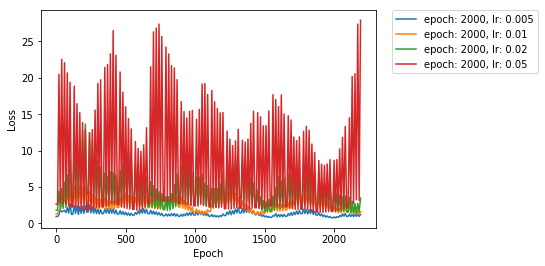

In [27]:
run_params = [
    {"learning_rate": .005, "epoch": 2000 },
    {"learning_rate": .01, "epoch": 2000 },
    {"learning_rate": .02 , "epoch": 2000},
    {"learning_rate": .05 , "epoch": 2000},
]
compare_runs(train_X,train_Y,test_X,test_Y,run_params)